# Question 2

The following data warehouse describes the trend over time of REIMBURSEMENT CLAIMS
received from different stores downstream of insurance coverages for electronic device models.
Specifically, the analysis should be done according to the electronic device model and its
category, list of insurance coverages subscribed (Legal Warranty, 3-Year Extension,
AccidentalDamage, Theft). lt is possible to subscribe multiple insurance covers for the same
device model (this list represents a configuration and each attribute assumes Y/N value). The data
warehouse stores the gender, residence, and age range of the buyer. For each store handling
claims, city, region, and corresponding geographic area are known. The metrics to analyze are the
number of claims received, the number of claims completed, the total amount claimed, the total
amount approved, and the duration of the claims processing expressed in days
(DurationTotProcess). Metrics should be analyzed for each date, month, 2-month, 3-month, 6-
month, year.

The data warehouse is characterized by the following conceptual scheme and the corresponding
logical scheme.

![Screenshot 2024-02-21 120614.png](<attachment:Screenshot 2024-02-21 120614.png>)

```sql
CREATE TABLE STORE(
    IDStore INT PRIMARY KEY,
    Store VARCHAR(50),
    City VARCHAR(50),
    Region VARCHAR(50),
    GeoArea VARCHAR(50)
);

CREATE TABLE DEVICE_MODEL(
    IDDeviceModel INT PRIMARY KEY,
    DeviceModel VARCHAR(50),
    Category VARCHAR(50),
);

CREATE TABLE JUNK_INSURANCE_COVERAGES(
    IDJIC INT PRIMARY KEY,
    LegalWarranty VARCHAR(50),
    ThreeYearExtension VARCHAR(50),
    AccidentalDamage VARCHAR(50),
    Theft VARCHAR(50)
);

CREATE TABLE JUNK_BUYER_FEATURES(
    IDJBF INT PRIMARY KEY,
    Gender VARCHAR(50),
    Residence VARCHAR(50),
    AgeRange VARCHAR(50),
);

CREATE TABLE TIME(
    IDTime INT PRIMARY KEY,
    Date DATE,
    Month DATE,
    TwoMonths DATE,
    ThreeMonths DATE,
    SixMonths DATE,
    Year DATE
);

CREATE TABLE REIMBURSEMENT_CLAIMS(
    IDStore INT,
    IDDeviceModel INT,
    IDJIC INT,
    IDJBF INT,
    IDTime INT,
    #ClaimsReceived INT,
    #ClaimsCompleted INT,
    AmountTotClaimed INT,
    AmountTotApproved INT,
    DurationTotProcessInDays INT,
    PRIMARY KEY (IDStore, IDDeviceModel, IDJIC, IDJBF, IDTime),
    FOREIGN KEY (IDStore) REFERENCES STORE(IDStore),
    FOREIGN KEY (IDDeviceModel) REFERENCES DEVICE_MODEL(IDDeviceModel),
    FOREIGN KEY (IDJIC) REFERENCES JUNK_INSURANCE_COVERAGES(IDJIC),
    FOREIGN KEY (IDJBF) REFERENCES JUNK_BUYER_FEATURES(IDJBF),
    FOREIGN KEY (IDTime) REFERENCES TIME(IDTime)
);
```

Given the above logic schema, consider the following queries of interest:
1. Considering the stores located in the northern geographic area, separately by store region
and year, show the total number of completed claims, the total approved amount, and the
average monthly duration of claims processing.
2. Considering insurance coverages that include accidental damage (attribute
AccidentalDamage), but not theft (attribute Theft), separately by month and store geographic
area, show the total number of completed claims and the difference between the total claimed
and the total approved amount.
3. Considering the years 2021 and 2022, separately by semester (6-Months attribute) and
store region, show the total number of completed claims and the corresponding average
approved amount.

Given the above logical scheme, answer the following requests:

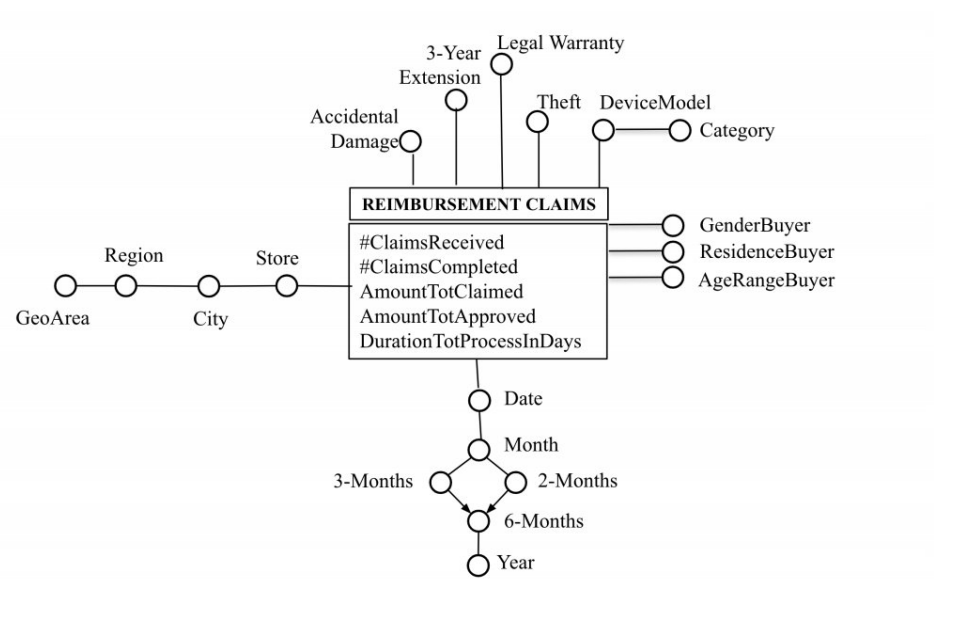

## Request 1

Define a materialized view with CREATE MATERIALIZED VIEW, so as to reduce the response time of the queries 1 to 3 above. SPecifically specify the SQL query associated with `Block A` in the following statement:

```sql
CREATE MATERIALIZED VIEW ViewReimbursements
BUILD IMMEDIATE
REFRESH FAST ON COMMIT
AS
Block A
```

In [ ]:
Block A
SELECT
    AccidentalDamage,
    Theft,
    GeoArea,
    Region,
    Month,
    SixMonths,
    Year,
    SUM(#ClaimsCompleted) AS TotCompletedClaims,
    SUM(AmountTotClaimed) AS TotClaimed,
    SUM(AmountTotApproved) AS TotApprovedAmount,
    SUM(DurationTotProcessInDays) AS TotDaysProcess
FROM
    STORE s,
    JUNK_INSURANCE_COVERAGES jic
    TIME t,
    REIMBURSEMENT_CLAIMS rc
WHERE
    rc.IDTime == t.IDTime
    AND rc.IDStore == s.IDStore
    AND rc.IDJIC == jic.IDJIC
GROUP BY
    AccidentalDamage,
    Theft,
    GeoArea,
    Region,
    Month,
    SixMonths,
    Year

## Request 2

Define the **minimal set** of attributes that allow identification of the tuples belonging to the materialized ViewReimbursement view

In [ ]:
(AccidentalDamage, Theft, Region, Month)

## Request 3

Assume that the management of the materialized View (derived table) is carried out by
means of triggers. Write the trigger to propagate to the ViewReimbursements materialized
View the changes due to the insertion of a new record into the REIMBURSEMENT-CLAIMS
table.

In [ ]:
CREATE
OR REPLACE TRIGGER TriggerViewReimbursements
AFTER
INSERT
    ON REIMBURSEMENT_CLAIMS FOR EACH ROW
    
DECLARE

N NUMBER;

VarAccidentalDamage,
VarTheft BOOLEAN;

VarGeoArea,
VarRegion VARCHAR(50);

VarMonth,
VarSixMonths,
VarYear DATE;

BEGIN
SELECT
    AccidentalDamage,
    Theft INTO VarAccidentalDamage,
    VarTheft
FROM
    JUNK_INSURANCE_COVERAGES jic
WHERE
    jic.IDJIC == :NEW.IDJIC;

SELECT
    GeoArea,
    Region INTO VarGeoAre,
    VarRegion
FROM
    STORE s
WHERE
    s.IDStore == :NEW.IDStore;

SELECT
    Month,
    SixMonths,
    Year INTO VarMonth,
    VarSixMonths,
    VarYear
FROM
    TIME t
WHERE
    t.IDTime == :NEW.IDTime;

SELECT
    COUNT(*) INTO N
FROM
    ViewReimbursements v
WHERE
    v.AccidentalDamage == :NEW.AccidentalDamage
    AND v.Theft == :NEW.Theft
    AND v.Region == :NEW.Region
    AND v.Month == :NEW.Month;

IF (N > 0) THEN
UPDATE
    ViewReimbursements v
SET
    TotCompletedClaims = TotCompletedClaims + :NEW. #ClaimsCompleted,
    TotClaimed = TotClaimed + :NEW.AmountTotClaimed,
    TotApprovedAmount = TotApprovedAmount + :NEW.AmountTotApproved,
    TotDaysProcess = TotDaysProcess + :NEW.TotDaysProcess
WHERE
    v.AccidentalDamage == :NEW.AccidentalDamage
    AND v.Theft == :NEW.Theft
    AND v.Region == :NEW.Region
    AND v.Month == :NEW.Month;

ELSE
INSERT INTO
    ViewReimbursements(
        AccidentalDamage,
        Theft,
        GeoArea,
        Region,
        Month,
        SixMonths,
        Year,
        TotCompletedClaims,
        TotClaimed,
        TotApprovedAmount,
        TotDaysProcess
    )
VALUES
    (
        VarAccidentalDamage,
        VarTheft,
        VarGeoArea,
        VarRegion,
        VarMonth,
        VarSixMonths,
        VarYear,
        :NEW. #ClaimsCompleted,
        :NEW.AmountTotClaimed,
        :NEW.AmountTotApproved,
        :NEW.TotDaysProcess
    );

END IF;

END;

# Question 10

Considering insurance coverages that include only the legal warranty (attribute LegalWarranty),
separately by 3-month period and store city, show:
- the percentage of completed claims compared to those received
- the average duration of processing per claim received

Associate each displayed record with a ranking position:
- according to the total amount approved separately by store geographic area (1 for the record
with the lowest total amount approved)
- according to the difference between the total claimed amount and the total approved amount
(1 for the record with the highest value of the difference between the total claimed amount and
the total approved amount) separately by year

In [ ]:
SELECT
    ThreeMonths,
    City,
    100 * SUM(#ClaimsCompleted) / SUM(#ClaimsReceived),
    SUM(DurationTotProcessingDays) / SUM(#ClaimsReceived),
    RANK() OVER (
        PARTITION BY GeoArea
        ORDER BY
            SUM(AmountTotApproved) ASC
    ),
    RANK() OVER (
        PARTITION BY Year
        ORDER BY
            SUM(AmountTotClaimed) - SUM(AmountTotApproved) DESC
    )
FROM
    JUNK_INSURANCE_COVERAGES jic,
    TIME t,
    STORE s,
    REIMBURSEMENT_CLAIMS rc
WHERE
    LegalWarranty == 'Y'
    AND ThreeYearExtension == 'N'
    AND AccidentalDamage == 'N'
    AND Theft == 'N'
    AND rc.IDJIC == jic.IDJIC
    AND rc.IDTime == t.IDTime
    AND rc.IDStore == s.IDStore
GROUP BY
    ThreeMonths,
    Year,
    City,
    GeoArea;

# Question 11

Considering the years before 2020, separately by electronic device model, semester (6-Months
attribute), and buyer gender, show:
- the average approved amount per completed claim
- the cumulative approved amount with passing semesters, separately by electronic device
model
- the cumulative claimed amount independently by device model, semester, and Gender

In [ ]:
SELECT
    DeviceModel,
    SixMonths,
    Gender,
    SUM(AmountTotApproved) / SUM(#ClaimsCompleted),
    SUM(
        SUM(AmountTotApproved) OVER (
            PARTITION BY DeviceModel
            ORDER BY
                SixMonths
            ROWS UNBOUNDED PRECEDING
        )
    ),
    SUM(
        SUM(AmountTotClaimed) OVER ()
    )
FROM
    TIME t,
    REIMBURSEMENT_CLAIMS rc,
    STORE s,
    JUNK_BUYER_FEATURES jbf
WHERE
    t.Year < 2020
    AND rc.IDTime == t.IDTime
    AND rc.IDStore == s.IDStore
    AND rc.IDJBF == jbf.IDJBF
GROUP BY
    DeviceModel
    SixMonths
    Gender

# Question 12

Separately by store, electronic device category, and 2-month period, show:
- the percentage of the requested amount that was approved
- the difference between the number of claims received and those completed
- the total approved amount independently of the store
- the ratio between the approved amount and the total approved amount of all stores located in
the same city, separately by electronic device category and 2-month period

In [ ]:
SELECT
    Store,
    Category,
    TwoMonths,
    100 * SUM(AmountTotApproved) / SUM(AmountTotClaimed),
    SUM(#ClaimsReceived) - SUM(#ClaimsCompleted),
    SUM(
        SUM(AmountTotApproved) OVER (PARTITION BY Category, TwoMonths)
    ),
    SUM(AmountTotApproved) / SUM(
        SUM(AmountTotApproved) OVER (PARTITION BY City, Category, TwoMonths)
    )
FROM
    STORE s,
    DEVICE_MODEL dm,
    TIME t,
    REIMBURSEMENT_CLAIMS rc
WHERE
    rc.IDStore == s.IDStore
    AND rc.IDDeviceModel == dm.IDDeviceModel
    AND rc.IDTime == t.IDTime
GROUP BY
    Store,
    Category,
    City,
    TwoMonths